In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import Input, Dense, Concatenate, Convolution2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1
from lib.preprocess_modules import load_pkl, save_pkl
from lib.dl_modules import *
from sklearn.preprocessing import normalize
from config import *
from pathlib import Path
import numpy as np
from numpy.random import shuffle, seed
import gc
import matplotlib.pyplot as plt
import os
from datetime import datetime

print("GPU data: \ndevice:", tf.test.gpu_device_name(), ", available:", tf.test.is_gpu_available())

GPU data: 
device: /device:GPU:0 , available: True


In [2]:
'''
Generate final dataset from separate files.
X: array of n_files*
y: array of n_files*
Save to pkl files.
'''
n_X_layers = 8
n_files = 300

X = np.zeros((n_files, 16, 32, n_X_layers))
y = np.zeros((n_files, 128))

sample = 0

for fname in os.listdir(foils_pkl_path): # сперва нужные профили
    if sample>n_files-1:break
    if fname[:2].lower() in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ]:
        foil = load_pkl(Path(foils_pkl_path, fname))
        for layer_n in range(X.shape[3]):
            X[sample, :, :, layer_n] = foil['X'][layer_n, ...]
        y[sample, :] = foil['y'].y.reshape(128)
        sample+=1

for fname in os.listdir(foils_pkl_path): # потом все оставшиеся
    
    if sample>n_files-1:break
    if fname[:2].lower() not in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht', 'X.', 'y.' ]:
        foil = load_pkl(Path(foils_pkl_path, fname))
        for layer_n in range(X.shape[3]):
            X[sample, :, :, layer_n] = foil['X'][layer_n, ...]
        y[sample, :] = foil['y'].y.reshape(128)
        sample+=1
    
assert np.sum(np.isnan(X))==0, "NaNs in X"
assert np.sum(np.isnan(y))==0, "NaNs in y"

save_pkl(X, Path(foils_pkl_path, "X.pkl"))
save_pkl(y, Path(foils_pkl_path, "y.pkl"))

print("Totally foils in arrays: %i" % (sample))

Totally foils in arrays: 300


In [3]:
X = load_pkl(Path(foils_pkl_path, 'X.pkl'))
y = load_pkl(Path(foils_pkl_path, 'y.pkl'))
# X = X.reshape(X.shape[0],16,16,16)
X.shape, y.shape

((300, 16, 32, 8), (300, 128))

In [4]:
all_indices = np.arange(len(X))
seed(42)
shuffle(all_indices)

n_indices = len(X)
train_part = int(n_indices*train_percentage)
val_part = int(n_indices*val_percentage)
train_part, val_part
train_indices = all_indices[:train_part]
val_indices = all_indices[train_part:val_part]
test_indices = all_indices[val_part:]

In [5]:
# NNs module

def contracting_unet(input_shape=(16, 32, 4), optimizer=Adam(1e-5), lr=1e-5, reg=0, batch_norm=True):
   # contracting path only
    inputs = Input(shape=input_shape)
    
    bn1 = BatchNormalization()(inputs) 
    
    conv1_input = bn1 if batch_norm else inputs     
    
    conv1 = Convolution2D(4, (2,2), activation='tanh', padding='same')(conv1_input)
    conv1 = Convolution2D(4, (2,2), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    flat = Flatten()(pool4)
    
    dense = Dense(2048, activation='tanh')(flat)
    dense = Dense(128, activation='tanh')(dense)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)

    model.compile(optimizer=optimizer, loss=MSE, metrics=['mse']) #mean_squared_error MeanSquaredError

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model

def full_unet(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0, batch_norm=True):
   
    inputs = Input(shape=input_shape)
    
    bn1 = BatchNormalization()(inputs) 
    
    conv1_input = bn1 if batch_norm else inputs 
    
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv1_input)
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(conv5)

    up6 = Concatenate()([Convolution2D(256, (2, 2), activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv5)), conv4])
    conv6 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(up6)
    conv6 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv6)

    up7 = Concatenate()([Convolution2D(128, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv6)), conv3])
    conv7 = Convolution2D(512, (2,2), activation='tanh', padding='same')(up7)
    conv7 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv7)
    
    up8 = Concatenate()([Convolution2D(64, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv7)), conv2])
    conv8 = Convolution2D(256, (2,2), activation='tanh', padding='same')(up8)
    conv8 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv8)
    
    up9 = Concatenate()([Convolution2D(32, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv8)), conv1])
    conv9 = Convolution2D(16, (2,2), activation='tanh', padding='same')(up9)
    conv9 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv9)
    
    conv10 = Convolution2D(1, (1, 1), activation='tanh')(conv9)

    flat = Flatten()(conv10)
    
    dense = Dense(128, activation='tanh')(flat)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
        model.layers[layer].kernel_initializer=1e-12
        model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MSE, metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model

In [8]:
# training
gc.collect()

n_epochs=11
batch_size=1
lr=1e-5
reg=0.1
optimizer=Adam(lr=lr)

model = full_unet(input_shape=X[0].shape, optimizer=optimizer, lr=lr, reg=reg, batch_norm=True)

# model.load_weights(str(Path("./weights", 'initial_weights_300foils_04122020.h5')))

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape)
test_generator  = BatchGenerator(X, y, test_indices, batch_size=batch_size, Xdim=X[0].shape, shuffle=False)

# callbacks
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=1, mode='min')
# lr_reduce = CosineLR(min_lr=1e-12, max_lr=lr, steps_per_epoch=np.ceil(len(train_indices)/batch_size), lr_decay=0.9)
# m_save = ModelCheckpoint(str(Path(results_path, 'weights', 'temp_weights.h5')), monitor='val_mse', 
#                          verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)

# train model
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                             verbose=1, workers=1, use_multiprocessing=False)

# save history and weights
# r_name = (str(datetime.now())[:16]).replace(':','-')
# unet.save_weights(str(Path(results_path,'weights', r_name+'.h5')))
# save_pkl(history.history, Path(results_path,'weights', r_name+'.pkl'))

print('Done.')
print("Val_loss: %2.4e" % np.min(history.history['val_loss']))

U-Net compiled
Input shape: (None, 16, 32, 8)
Output shape: (None, 128)
Epoch 1/11
225/225 [==============================] - 20s 90ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 2/11
225/225 [==============================] - 19s 86ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/11
225/225 [==============================] - 20s 87ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 4/11
225/225 [==============================] - 20s 87ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5/11
225/225 [==============================] - 19s 86ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/11
225/225 [==============================] - 19s 86ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 7/11
225/225 [==============================] - 19s 85ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0066 - val_ms

## Summary

- Поменял форму входных данных на 16х32, взял два типа сети: только сontracting path и полную. 
- val_loss крутится в районе 3е-4, визуально картинка жуть.


Всё с нормализацией входа

### 138 шт на 8 слоев:
n_epochs=10000
batch_size=1
lr=1e-5
reg=0.1
optimizer=Adam(lr=lr)
- contracting_unet: Val_loss: 8.0065e-05 - зубчики
- full_unet: Val_loss: 3.1539e-03 - стохастические данные

### 138 шт на 6 слоев, без Re и альфа:
n_epochs=10000
batch_size=1
lr=1e-5
reg=0.1
optimizer=Adam(lr=lr)
- contracting_unet: Val_loss: 2.4468e-04 зубчики
- full_unet: Val_loss: 1.6331e-03 - очень большие зубцы

### 300 шт на 8 слоев:
n_epochs=10000
batch_size=1
lr=1e-5
reg=0.1
optimizer=Adam(lr=lr)
- contracting_unet: Val_loss: 3.2880e-04 - зубчики
- full_unet: Val_loss: val_mse: 0.0025 - стохастично все

## Заключение

Ничего серьезного при данном подходе не выходит, закончил с ним.




0.16801038 0.10154352532880516


[]

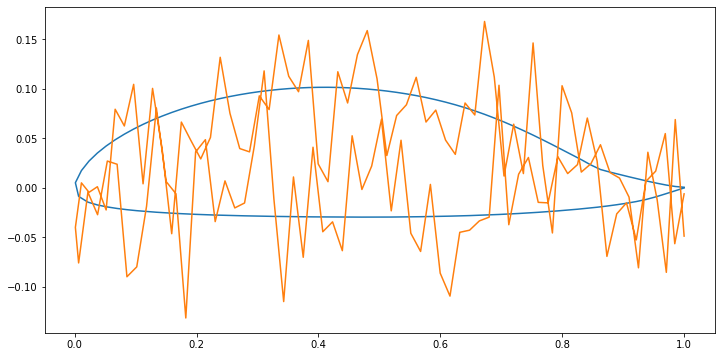

In [7]:
sample_n = 6

X_pred, y_targ = test_generator[sample_n]
X_pred = X_pred[0]
y_targ = y_targ[0]
y_pred = model.predict(np.expand_dims(X_pred,axis=0))
print(np.max(y_pred), np.max(y_targ))
plt.figure(figsize=(12,6))
plt.plot(foil['y'].x, y_targ), plt.plot(foil['y'].x, y_pred[0,])#, plt.plot([0,0],[-0.3,0.3])
plt.plot()

In [ ]:
# # save history and weights
# from datetime import datetime

# r_name = (str(datetime.now())[:16]).replace(':','-')
# model.save_weights(str(Path(weights_path, r_name+'.h5')))
# save_pkl(history.history, Path(weights_path, r_name+'.pkl'))